### paths

In [1]:
import os
import sys
import numpy as np

proj_base_path = '../../'
data_base_path = '../../datasets'
models_base_path = '../../pretrained_models'
sys.path.append(os.path.join(os.getcwd(), proj_base_path))

dataset_path = 'numpy/pokemon100ms_no_vel_transposed/meta/'
dataset_file = '_dicted_dataset_ignore_ratio=0.05.npy'
word_vectors_file = '_word_vectors_1000_ignore_ratio=0.05.wv'

track_path = os.path.join(data_base_path, dataset_path, dataset_file)
word_vectors_path = os.path.join(data_base_path, dataset_path, word_vectors_file)

### loading embedding

In [2]:
from gensim.models import KeyedVectors

wv = KeyedVectors.load(word_vectors_path, mmap='r')

### loading model

In [3]:
from tensorflow import keras as K

model_dir = 'lstm/embedded_16_128/'
model_file = 'md_e1_t2019-10-12T11:21:54.h5'
model = K.models.load_model(os.path.join(models_base_path, model_dir, model_file))

W1012 11:22:51.606720 4736587200 deprecation.py:506] From /usr/local/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1012 11:22:51.607815 4736587200 deprecation.py:506] From /usr/local/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1012 11:22:51.608874 4736587200 deprecation.py:506] From /usr/local/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:97: calling Orthogonal.__init__ (from tensorflow.python.ops.init_ops) with dtype is depre

### creating output dir

In [5]:
output_dir = os.path.join(models_base_path, model_dir, 'samples')
os.makedirs(output_dir, exist_ok=True)

print(f'saving samples to {output_dir}')

saving samples to ../../pretrained_models/lstm/embedded_16_128/samples


### importing and preparing seed generators

In [6]:
from src.generating.embedded_generating_seeds import seed_generators

seed_gens = [
    ('random_noise_seed', lambda length, input_size, wv, batch_size: seed_generators['random_noise_seed'](
        length, input_size, scaler=2.0, batch_size=batch_size)),
    ('zero_seed', lambda length, input_size, wv, batch_size: seed_generators['zero_seed'](
        length, input_size, wv, batch_size=batch_size)),
    ('const_frame_seed', lambda length, input_size, wv, batch_size: seed_generators['const_frame_seed'](
        length, input_size, wv, batch_size=batch_size)),
    ('short_frame_seed', lambda length, input_size, wv, batch_size: seed_generators['short_frame_seed'](
        length, input_size, wv, batch_size=batch_size)),
    ('multi_note_seed', lambda length, input_size, wv, batch_size: seed_generators['multi_note_seed'](
        length, input_size, wv, batch_size=batch_size)),
    ('multi_note_harmonic_seed', lambda length, input_size, wv, batch_size: seed_generators['multi_note_harmonic_seed'](
        length, input_size, wv, batch_size=batch_size)),
    ('const_frame_seed_noise', lambda length, input_size, wv, batch_size: seed_generators['const_frame_seed_noise'](
        length, input_size, word_vectors=wv, batch_size=batch_size)),
    ('short_frame_seed_noise', lambda length, input_size, wv, batch_size: seed_generators['short_frame_seed_noise'](
        length, input_size, word_vectors=wv, batch_size=batch_size)),
    ('multi_note_seed_noise', lambda length, input_size, wv, batch_size: seed_generators['multi_note_seed_noise'](
        length, input_size, word_vectors=wv, batch_size=batch_size)),
    ('multi_note_harmonic_seed_noise', lambda length, input_size, wv, batch_size: seed_generators['multi_note_harmonic_seed_noise'](
        length, input_size, word_vectors=wv, batch_size=batch_size)),
]

### defining generating constants

In [15]:
from src.data_processing.common.rw_np_mid import read_numpy_midi, save_numpy_midi
from src.generating.generating import recurrent_generate
from src.data_processing.embedding_sparse_notes.reverse_transform import np2sparse
from src.data_processing.sparse_notes_quantized_time.np2mid import np2mid
import matplotlib.pyplot as plt
from time import time

In [16]:
SEED_LENGTH = 50
SEQ_LENGTH = 400
INPUT_SIZE = 16
WINDOW_SIZE = 100
BATCH_SIZE = 1

decoding track with 100 resolution


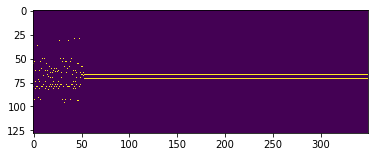

decoding track with 100 resolution


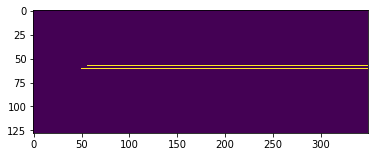

decoding track with 100 resolution


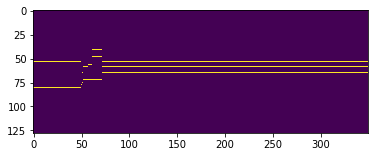

decoding track with 100 resolution


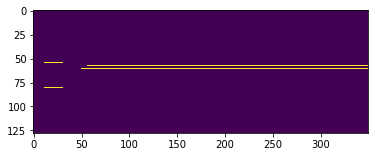

decoding track with 100 resolution


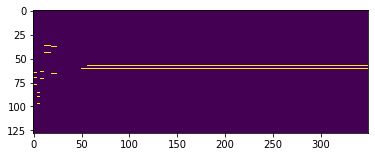

decoding track with 100 resolution


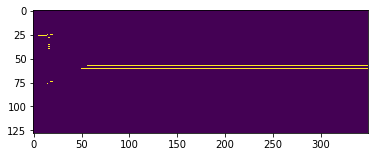

decoding track with 100 resolution


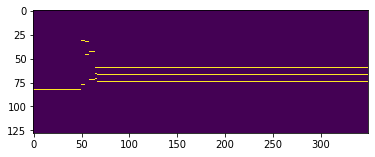

decoding track with 100 resolution


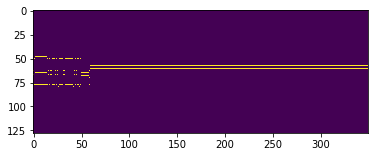

decoding track with 100 resolution


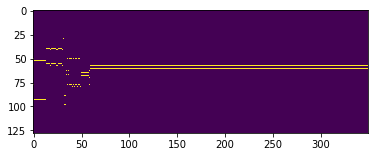

decoding track with 100 resolution


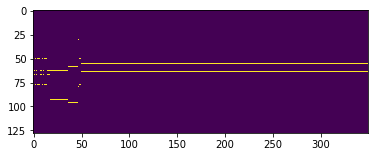

In [17]:
for name, gen in seed_gens:
    seed = gen(SEED_LENGTH, INPUT_SIZE, wv, BATCH_SIZE)
    samples = recurrent_generate(
        model, seed, SEQ_LENGTH, WINDOW_SIZE)
    sparse_samples = [np2sparse(sample, wv)[0]
                      for sample in samples]
    for i, sample in enumerate(sparse_samples):
        name = f'{model_file}_{name}_{time()}_{i}'
        mid = np2mid(sample.toarray())
        mid.save(f'{name}.mid')
        fig = plt.figure()
        plt.imshow(sample.toarray().T[::-1, :])
        fig.savefig(f'{name}.png', dpi=fig.dpi)
        plt.show()